# MVO

The Mean-Variance Optimization (MVO) is formulated as follows.

## Parameters (assumed constant during optimization)

$n$: number of stocks in the portfolio

$\mathbf{\mu}$: vector of expected returns for each stock

$\Sigma$: covariance matrix of returns

$\lambda$: risk aversion coefficient defined by user.

## Decision variables
$\mathbf{w}$: vector of fractions of the total investment allocated to each stock.

## Formulation

The objective is to maximize the expected return of the portfolio minus a penalty for risk, subject to constraints on the investment fractions.

The formulation can be written as follows:

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \mathbf{\mu}^T \mathbf{w} - \lambda \mathbf{w}^T \Sigma \mathbf{w} \\
& \text{subject to}
& & \sum_{i=1}^n w_i = 1, \\
& & & w_i \geq 0 \, \forall i \in \{1, \ldots, n\}.
\end{aligned}
$$

where:

1. **Objective Function**:
   - $\mathbf{\mu}^T \mathbf{w}$ denotes the expected return of the portfolio, $\mathbf{\mu}$ is the vector of mean returns for each stock and $\mathbf{w}$ is the vector of investment fractions.
   - $\lambda \mathbf{w}^T \Sigma \mathbf{w}$ denotes the risk penalty, where $\Sigma$ is the covariance matrix of returns, and $\phi$ is the risk aversion coefficient. The expression $\mathbf{w}^T \Sigma \mathbf{w}$ computes the variance of the portfolio return.

2. **Constraints**:
   - $\sum_{i=1}^n w_i = 1$ enforces that the sum of the investment fractions equals 1, ensuring that the entire budget is invested.
   - $w_i \geq 0 \, \forall i \in \{1, \ldots, n\}$ enforces that the investment fractions are non-negative, which disallows short selling.


In the following code snippet, we assume:

1. **Mean Return ($ \mu_i $)**:
   The mean return of stock $ i $ is given by the formula:
   $ \mu_i = 1.15 + \frac{i \cdot 0.05}{150} $
   This formula linearly increases the mean return of each stock by a small increment as the stock index $ i $ increases.

2. **Standard Deviation ($ \sigma_i $)**:
   The standard deviation of return of stock $ i $ is given by the formula:
   $ \sigma_i = \frac{0.05}{450} \cdot (2i \cdot n \cdot (n + 1))^{0.5} $
   This formula computes the standard deviation based on the stock index $ i $ and the total number of stocks $ n $, with some constants to scale the values.

3. **Portfolio covariance matrix ($ \Sigma $**):
  The covariance matrix $\Sigma$ is constructed as a diagonal matrix with the variances of individual stock returns along the diagonal, which implies an assumption of no correlation between the returns of different stocks. This assumption simplifies the risk penalty term to $\lambda \sum_{i=1}^n \sigma_i^2 w_i^2$, where $ \sigma_i$ denotes the standard deviation of returns for stock $ i $.


Thus the MVO model becomes:

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \sum_{i=1}^n \mu_i w_i - \lambda \sum_{i=1}^n \sigma_i^2 w_i^2 \\
& \text{subject to}
& & \sum_{i=1}^n w_i = 1, \\
& & & w_i \geq 0 \, \forall i \in \{1, \ldots, n\}.
\end{aligned}
$$


In a real-world scenario, the mean returns and standard deviations would typically be estimated from historical data or based on other financial models rather than being defined by such algebraic expressions.

Reference:

Ben-Tal, Aharon, and Arkadi Nemirovski. 1999. Robust solutions of uncertain linear programs. Operations Research Letters 25(1) 1-13.

Also see https://xiongpengnus.github.io/rsome/example_mv_portfolio#ref1

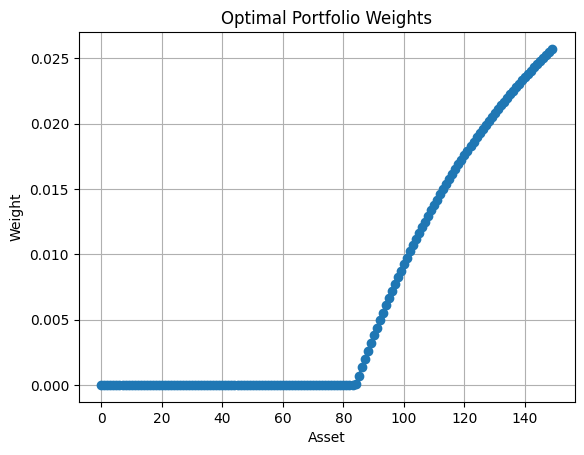

The optimal risk-adjusted return is: 1.185339385889329


In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class PortfolioOptimizer:
    def __init__(self, n_stocks, risk_aversion):
        self.n = n_stocks  # number of stocks
        self.lamb = risk_aversion  # risk aversion coefficient
        self.mu = 1.15 + np.arange(1, n_stocks+1) * 0.05 / n_stocks # asset wise mean return
        self.sigma = 0.05 / 450 * (2 * np.arange(1, n_stocks+1) * n_stocks * (n_stocks + 1))**0.5 # asset wise volatility
        self.Q = np.diag(self.sigma**2) # asset covariance matrix

    # Calculate the risk-adjusted return given weights w
    def risk_adjusted_return(self, w):
        expected_return = np.dot(self.mu, w) # expected return of the portfolio given the weights
        variance = np.dot(w.T, np.dot(self.Q, w)) # variance of the portfolio given the weights
        return expected_return - self.lamb * variance

    # Objective function
    def objective(self, w):
        return -self.risk_adjusted_return(w)  # Negating the expression for minimization

    # Solve the MVO problem
    def solve_mvo(self):
        constraints = ({'type': 'eq', 'fun': self.constraint_sum})
        bounds = [(0, 1) for _ in range(self.n)]
        w0 = np.repeat(1 / self.n, self.n)
        result = minimize(self.objective, w0, bounds=bounds, constraints=constraints, method='SLSQP')
        optimal_risk_adjusted_return = -result.fun  # Negate to get the actual value since the objective was negated for minimization
        return result.x, optimal_risk_adjusted_return

    # Constraint function
    def constraint_sum(self, w):
        return np.sum(w) - 1

    # Plot solution
    def plot_solution(self, weights):
        plt.plot(np.arange(self.n), weights, '-o')  # Using 'plot' method with line and marker
        plt.xlabel('Asset')
        plt.ylabel('Weight')
        plt.title('Optimal Portfolio Weights')
        plt.grid(True)  # Optional: Adds a grid for better readability
        plt.show()


# Usage example:
n_stocks = 150
risk_aversion = 5
optimizer = PortfolioOptimizer(n_stocks, risk_aversion)
opt_weights, optimal_rar = optimizer.solve_mvo()

# Plot solution
optimizer.plot_solution(opt_weights)

# Print the optimal risk-adjusted return
print(f"The optimal risk-adjusted return is: {optimal_rar}")

# Robust MVO

## Sensitivity to estimation error

In practice, the expected return vector $\mathbf{\mu}$ and covariance matrix $\Sigma$ need to be estimated by $\mathbf{\hat{\mu}}$ and $\hat{\Sigma}$, respectively, using historical data. It was shown that the resulting optimal portfolio (specifically, the allocation weights) is sensitive to these estimates. In particular, it is ten times more sensitive to $\mathbf{\hat{\mu}}$ than $\hat{\Sigma}$. This means that a small change in $\mathbf{\hat{\mu}}$ results in a big change in the resulting allocation $\mathbf{\hat w^*}$.

In other words, a small change in the input parameter causes a big change in the output decision. One way to insensitize the portfolio to the input parameters of predicted return vector $\mathbf{\hat \mu}$ is to apply robust optimization and optimize over the worst case scenarios.

**Discussion**: how to compare the result of robust MVO with normal MVO? Does robust MVO display smaller change when the mean return changes?

## General formulation of robust MVO

Now we assume an unknown mean return vector $\mathbf{\mu}$ and covariance $\Sigma$ instead of a fixed vector $\mathbf{\hat \mu}$ and matrix $\hat \Sigma$. These two random parameters will change within the corresponding **uncertainty set** $U_\mathbf{\mu}$ and $U_\Sigma$:


$$
\mu \in U_\mathbf{\mu} \\
\Sigma \in U_\Sigma
$$

We will consider the worst-case scenarios within these uncertainty sets, giving rise to the following robust MVO formulation:

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \underset{\mathbf{\mu} \in U_\mathbf{\mu}}{\text{min}} \mathbf{\mu}^T \mathbf{w} - \lambda \underset{\Sigma \in U_\Sigma}{\text{max}} \mathbf{w}^T \Sigma \mathbf{w} \\
& \text{subject to}
& & \mathbf{w}^T \mathbf{1} = 1, \\
& & & w_i \geq 0 \, \forall i \in \{1, \ldots, n\}.
\end{aligned}
$$

Two key questions arise:
- how do we choose the uncertainty sets $U_\mu$ and $U_\Sigma$, and
- how to solve the optimization problem efficiently


## Box constraint on mean vector



Assume a fixed covariance matrix estimate $\hat{\Sigma}$ and consider the following component-wise box uncertainty set $U_\mathbf{\mu}$ for $\mathbf{\mu}$:

$$
U_\mathbf{\mu} = \{\mathbf{\mu} | -\mathbf{\delta} \leq \mathbf{\mu} - \bar{\mathbf{\mu}} \leq \mathbf{\delta} \}
$$

where

- $\bar{\mathbf{\mu}}$ is a pre-defined location of the box uncertainty set
- $\mathbf{\delta}$ is a pre-defined size of the box uncertainty set

The MVO formulation now becomes:

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \underset{\mathbf{\mu} \in U_\mathbf{\mu}}{\text{min}} \mathbf{\mu}^T \mathbf{w} - \lambda \mathbf{w}^T \hat \Sigma \mathbf{w} \\
& \text{subject to}
& & \mathbf{w}^T \mathbf{1} = 1
\end{aligned}
$$

where we now consider a more general case after removing the nonnegative constraint.

We note an equivalent form of the inner minimization problem:

$$
\underset{\mathbf{\mu} \in U_\mathbf{\mu}}{\text{min}} \mathbf{\mu}^T \mathbf{w} = \mathbf{\bar{\mu}}^T \mathbf{w} - \mathbf{\delta} |\mathbf{w}|
$$

That is, the minimizing the expected return results in the worst-case return across the whole domain $U_\mathbf{\mu}$. Since $\bar{\mathbf{\mu}} - \mathbf{\delta} \leq \mathbf{\mu} \leq \bar{\mathbf{\mu}} + \mathbf{\delta}$, and the function $\mathbf{\mu}^T \mathbf{w}$ is monotone is $\mu$, we observe that the minimal value is obtained at the end points, depending on the sigh of the weight value $\mathbf{w}$.

Specifically, for any asset weight $w_i$, $i \in \{1,...,n\}$
- when $w_i \geq 0$, $\underset{\mu_i \in U_{\mu_i}}{\text{min}} \mu_i w_i=\bar{\mu_i}w_i-\delta w_i$.
- when $w_i < 0$, $\underset{\mu_i \in U_{\mu_i}}{\text{min}} \mu_i w_i=\bar{\mu_i}w_i+\delta w_i$.

Both cases can be written together via the following:

$$
\underset{\mu_i \in U_{\mu_i}}{\text{min}} \mu_i w_i=\bar{\mu_i}w_i-\delta |w_i|
$$

Thus, we can convert the previous problem to the following equivalent formulation:

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \mathbf{\bar{\mu}}^T \mathbf{w} - \mathbf{\delta} |\mathbf{w}| - \lambda \mathbf{w}^T \hat \Sigma \mathbf{w} \\
& \text{subject to}
& & \mathbf{w}^T \mathbf{1} = 1
\end{aligned}
$$

To solve this, we resort to a standard trick to get rid of the absolute value operation in $|\mathbf{w}|$, giving:

$$
\begin{align}
\underset{\mathbf{w}, \mathbf{\psi}}{\text{maximize}} \quad & \mathbf{\bar{\mu}}^T \mathbf{w} - \mathbf{\delta} \mathbf{\psi} - \lambda \mathbf{w}^T \hat \Sigma \mathbf{w} \\
\text{subject to} \quad & \mathbf{w}^T \mathbf{1} = 1, \\
& \psi_i \geq w_i, \quad \psi_i \geq -w_i, \quad i \in \{1,...,N\}
\end{align}
$$

Here, we introduce a new unknown vector $\mathbf{\psi} \in \mathbb{R}^N$ to be optimized over together with $\mathbf{w}$. This means the number of decision variables is doubled. However, we can also directly use $|\mathbf{w}|$ in the optimization procedure when assuming a long only portfolio.


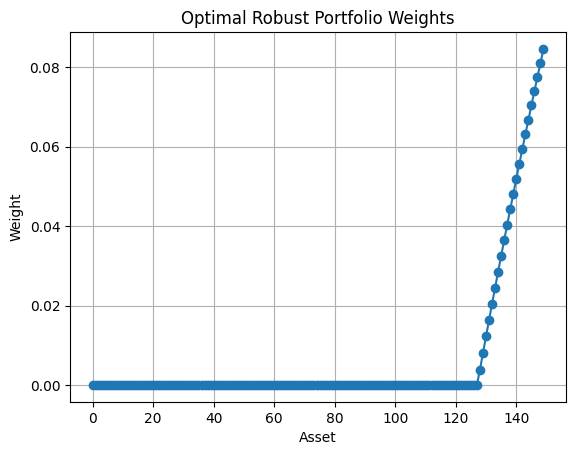

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class RobustPortfolioOptimizer:
    def __init__(self, n_stocks, lambda_val, delta):
        self.n = n_stocks  # Number of stocks
        self.lambda_val = lambda_val  # Risk aversion coefficient
        self.delta = delta  # Delta for robustness
        self.mu_bar = 1.15 + np.arange(1, n_stocks + 1) * 0.05 / n_stocks
        sigma = 0.05 / 450 * (2 * np.arange(1, n_stocks + 1) * n_stocks * (n_stocks + 1))**0.5
        self.Q = np.diag(sigma**2)  # Covariance matrix

    def objective(self, params):
        w, psi = params[:self.n], params[self.n:]
        expected_return = np.dot(self.mu_bar, w)
        variance = np.dot(w.T, np.dot(self.Q, w))
        abs_w_penalty = self.delta * np.sum(psi)
        return -(expected_return - abs_w_penalty - self.lambda_val * variance)

    def constraint_sum(self, w_psi):
        return np.sum(w_psi[:self.n]) - 1

    def constraint_psi_pos(self, w_psi):
        return w_psi[self.n:] - w_psi[:self.n]

    def constraint_psi_neg(self, w_psi):
        return w_psi[self.n:] + w_psi[:self.n]

    def solve_optimization(self):
        constraints = (
            {'type': 'eq', 'fun': self.constraint_sum},
            {'type': 'ineq', 'fun': self.constraint_psi_pos},
            {'type': 'ineq', 'fun': self.constraint_psi_neg}
        )
        bounds = [(0, 1) for _ in range(self.n)] + [(0, 1) for _ in range(self.n)]
        x0 = np.repeat(1/(2*self.n), 2*self.n)
        result = minimize(self.objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')
        return result.x[:self.n]  # Return only the weights, not psi

    def plot_solution(self, weights):
        plt.plot(np.arange(self.n), weights, '-o')
        plt.xlabel('Asset')
        plt.ylabel('Weight')
        plt.title('Optimal Robust Portfolio Weights')
        plt.grid(True)
        plt.show()

# Usage example:
n_stocks = 150
lambda_val = 0.5
delta = 0.05

robust_optimizer = RobustPortfolioOptimizer(n_stocks, lambda_val, delta)
optimal_weights = robust_optimizer.solve_optimization()

# # Print optimal weights
# print("Optimal Weights:", optimal_weights)

# Plot the solution
robust_optimizer.plot_solution(optimal_weights)


The robust solution shows that more weights are set to zero. This tallys with the interpretation that subtracting the weighted l1 norm of the decision variables (portfolio weights) is equivalent to adding a l1 penalty, thus producing a sparse solution.

## Box constraint on covariance matrix

In a manner analogous to the box uncertainty applied to the mean return vector, a similar concept can be implemented for the covariance matrix of the portfolio. Let us denote the nominal covariance matrix by $\bar \Sigma$, typically estimated using historical sample data. Rather than using a fixed $\bar \Sigma$ in MVO and in order to consider uncertainty in the covariance matrix, we introduce a degree of variability by incorporating an additive random perturbation matrix $\Delta$. This matrix is a symmetric $N \times N$ matrix and adheres to the following inequality constraint:

$$
|\Delta_{ij}| \leq \kappa (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}}    
$$

Here, each element $\Delta_{ij}$ is bounded by a scaled version of the square root of $\sigma_i^2 \sigma_j^2$, for each pair of assets $i$ and $j$. This implies that the allowed deviation for the covariance estimate between assets \textit{i} and \textit{j} is proportionate to the geometric mean of their individual variances. Thus, larger variances (indicating higher volatility) can lead to greater uncertainty in the covariance estimates.

The scaling factor $\kappa$ typically takes values such as 0.02 or 0.05, indicating moderate levels of uncertainty. This factor reflects the proportional uncertainty in the covariance estimate, acknowledging potential estimation errors or fluctuations over time. Consequently, the covariance matrix $\Sigma$ used in the optimization model is represented as

$$
\Sigma = \bar \Sigma + \Delta
$$

In this model, $\Delta$ is constrained by \ref{eq1}, which imposes a percentage-based relative threshold. The input parameter $\Sigma$ is thus belongs to the following uncertainty set:

$$
U_{\Sigma} = \{\Sigma | \bar \Sigma - \kappa (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}} \leq \Sigma_{ij} \leq \bar \Sigma + \kappa (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}}, \forall i, j \in \{1,\cdots, N\}\}
$$

This contrasts with the absolute value-based threshold used for the mean return vector, and it aligns with the nature of covariance estimates which are often variable and subject to estimation errors. This approach to robust portfolio optimization helps to account for the uncertainty inherent in the estimation of covariances, leading to a portfolio construction that is potentially more resilient to estimation errors.

The MVO formulation now becomes:

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \boldsymbol{\mu}^T \mathbf{w} - \lambda \underset{\Sigma \in U_\Sigma}{\text{max}} \mathbf{w}^T \Sigma \mathbf{w} \\
& \text{subject to}
& & \mathbf{w}^T \mathbf{1} = 1, \\
& & & w_i \geq 0 \, \quad \forall i \in \{1, \ldots, n\}.
\end{aligned}
$$

Let us focus on the inner maximization term $\underset{\Sigma \in U_\Sigma}{\text{max}} \mathbf{w}^T \Sigma \mathbf{w}$, which can be further simplified as follows.

$$
\begin{aligned}
     \underset{|\Delta_{ij}| \leq \kappa (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}}  }{\text{max}} \mathbf{w}^T \Sigma \mathbf{w}  &= \underset{|\Delta_{ij}| \leq \kappa (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}}  }{\text{max}}  \mathbf{w}^T (\bar \Sigma + \Delta) \mathbf{w} \\
    &= \mathbf{w}^T \bar \Sigma \mathbf{w} + \underset{|\Delta_{ij}| \leq \kappa (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}}  }{\text{max}}  \mathbf{w}^T \Delta \mathbf{w} \\
    &= \mathbf{w}^T \bar \Sigma \mathbf{w} + \underset{|\Delta_{ij}| \leq \kappa (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}}  }{\text{max}} \sum_{ij}  w_i w_j \Delta_{ij} \\
    &= \mathbf{w}^T \bar \Sigma \mathbf{w} + \kappa \sum_{ij}  |w_i w_j| (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}} \\
    &= \mathbf{w}^T \bar \Sigma \mathbf{w} + \kappa \big ( \sum_{i}  |w_i| (\bar \Sigma_{ii})^{\frac{1}{2}} \big )^2
\end{aligned}
$$
where the third equality reflects the pairwise contributions of the uncertainty in covariance estimates, and the fourth equality represents the maximum additional variance due to the uncertainty in the covariance matrix. To see the fifth equality, note that the term $\sum_{ij}  |w_i w_j| (\bar \Sigma_{ii} \bar \Sigma_{jj})^{\frac{1}{2}}$ mimics the portfolio variance calculated by weight $|w_i|$ for each asset $i \in \{1,\cdots,N\}$ and a covariance matrix with perfect correlation, i.e., $\rho_{ij}=1$ for all $i,j \in \{1,\cdots,N\}$.


Reference:

Multi-Period Trading via Convex Optimization

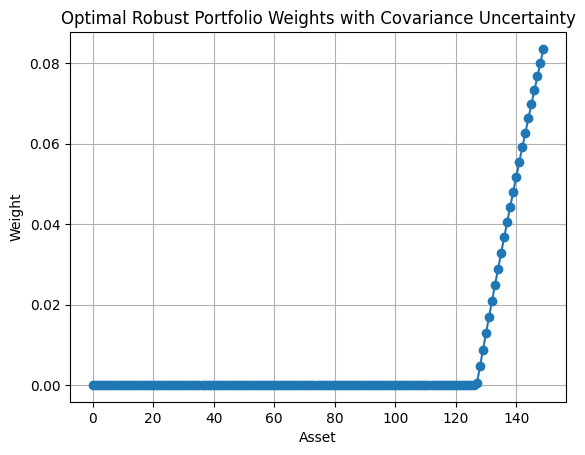

In [ ]:
class RobustPortfolioOptimizerWithCovarianceUncertainty:
    def __init__(self, n_stocks, lambda_val, kappa):
        self.n = n_stocks  # Number of stocks
        self.lambda_val = lambda_val  # Risk aversion coefficient
        self.kappa = kappa  # Kappa for covariance uncertainty

        # Define nominal mean returns and covariance matrix
        self.mu_bar = 1.15 + np.arange(1, n_stocks + 1) * 0.05 / n_stocks
        sigma = 0.05 / 450 * (2 * np.arange(1, n_stocks + 1) * n_stocks * (n_stocks + 1))**0.5
        self.Q_bar = np.diag(sigma**2)  # Nominal covariance matrix

    def objective(self, w):
        expected_return = np.dot(self.mu_bar, w)
        variance = np.dot(w.T, np.dot(self.Q_bar, w))

        # Calculate the maximum additional variance due to uncertainty
        additional_variance = self.kappa * np.sum([abs(w[i]) * np.sqrt(self.Q_bar[i, i]) for i in range(self.n)]) ** 2

        # Total risk is the sum of nominal variance and additional variance
        total_risk = variance + additional_variance

        return -(expected_return - self.lambda_val * total_risk)

    def constraint_sum(self, w):
        return np.sum(w) - 1

    def solve_optimization(self):
        constraints = {'type': 'eq', 'fun': self.constraint_sum}
        bounds = [(0, 1) for _ in range(self.n)]
        x0 = np.repeat(1 / self.n, self.n)
        result = minimize(self.objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')
        return result.x  # Return only the weights

    def plot_solution(self, weights):
        plt.plot(np.arange(self.n), weights, '-o')
        plt.xlabel('Asset')
        plt.ylabel('Weight')
        plt.title('Optimal Robust Portfolio Weights with Covariance Uncertainty')
        plt.grid(True)
        plt.show()

# Usage example:
n_stocks = 150
lambda_val = 0.5
kappa = 0.05

robust_optimizer = RobustPortfolioOptimizerWithCovarianceUncertainty(n_stocks, lambda_val, kappa)
optimal_weights = robust_optimizer.solve_optimization()
robust_optimizer.plot_solution(optimal_weights)


## Elliptical Uncertainty over Mean Return

It is often difficult to accurately estimate the expected returns $\boldsymbol{\mu}$. To account for the estimation error, we can introduce an elliptical uncertainty set which models the potential deviations of the expected returns from their nominal estimates $\boldsymbol{\hat \mu}$.

The elliptical uncertainty set is formally defined as:

$$
U_{\boldsymbol{\mu}} = \left\{ \boldsymbol{\mu} \mid (\boldsymbol{\mu} - \boldsymbol{\hat \mu})^T \boldsymbol{S}^{-1} (\boldsymbol{\mu} - \boldsymbol{\hat \mu}) \leq \delta^2 \right\}
$$

where $\boldsymbol{S}^{-1}$ is the inverse of a positive definite matrix that shapes the ellipsoid, and $\delta$ represents the "radius" of the ellipsoid in standard deviations, delineating the extent to which $\boldsymbol{\mu}$ can differ from $\boldsymbol{\hat \mu}$.

An equivalent representation of the uncertainty set, emphasizing its geometric nature, is as follows:

$$
U_{\boldsymbol{\mu}} = \left\{ \boldsymbol{\mu} = \boldsymbol{\hat \mu} + \delta \boldsymbol{S}^{1/2} \mathbf{u} \mid \quad \| \mathbf{u}\|_2 \leq 1 \right\}
$$

Here, $\mathbf{u}$ extends the surface of a unit ball, scaled by $\delta$ (a positive scalar) and transformed by the matrix $\boldsymbol{S}^{1/2}$. The matrix $\boldsymbol{S}$, which can be set as the estimated covariance matrix $\boldsymbol{\hat \Sigma}$, incorporates historical variances and covariances of asset returns, thus integrating our confidence in these estimates into the uncertainty set.

When applying this uncertainty set to the MVO problem, we arrive at a robust optimization formulation.

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \underset{\boldsymbol{\mu} \in U_{\boldsymbol{\mu}}}{\text{min}} \quad \mathbf{w}^T \boldsymbol{\mu} - \lambda \mathbf{w}^T \boldsymbol{\hat \Sigma} \mathbf{w} \\
& \text{subject to}
& & \mathbf{1}^T \mathbf{w} = 1 \\
& & & \mathbf{w} \geq \mathbf{0}
\end{aligned}
$$

The inner minimization problem can be expressed as

$$
\begin{aligned}
    \underset{\boldsymbol{\mu} \in U_{\boldsymbol{\mu}}}{\text{min}} \quad \mathbf{w}^T \boldsymbol{\mu}
    &= \underset{\|\mathbf{u}\|_2 \leq 1}{\text{min}} \quad \mathbf{w}^T (\boldsymbol{\hat \mu} + \delta \boldsymbol{S}^{1/2} \mathbf{u}) \\
    &= \mathbf{w}^T \boldsymbol{\hat \mu} + \underset{\|\mathbf{u}\|_2 \leq 1}{\text{min}} \quad \delta \mathbf{u}^T (\boldsymbol{S}^{1/2})^T \mathbf{w} \\
    &= \mathbf{w}^T \boldsymbol{\hat \mu} - \delta \|(\boldsymbol{S}^{1/2})^T \mathbf{w}\|_2
\end{aligned}
$$

This simplification leverages the property that the minimum value of $\mathbf{u}^T \mathbf{z}$ for a given vector $\mathbf{z}$ and $\|\mathbf{u}\|_2 \leq 1$ is $-\|\mathbf{z}\|_2$.

Consequently, the robust MVO problem is formulated as follows.

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \mathbf{w}^T \boldsymbol{\hat \mu} - \lambda \mathbf{w}^T \boldsymbol{\hat \Sigma} \mathbf{w} - \delta \|(\boldsymbol{S}^{1/2})^T \mathbf{w}\|_2 \\
& \text{subject to}
& & \mathbf{1}^T \mathbf{w} = 1 \\
& & & \mathbf{w} \geq \mathbf{0}
\end{aligned}
$$

Here, the term $-\delta \|(\boldsymbol{S}^{1/2})^T \mathbf{w}\|_2$ represents the worst-case deviation of expected returns within the uncertainty ellipsoid, effectively hedging against the risk of underestimation of the true returns.


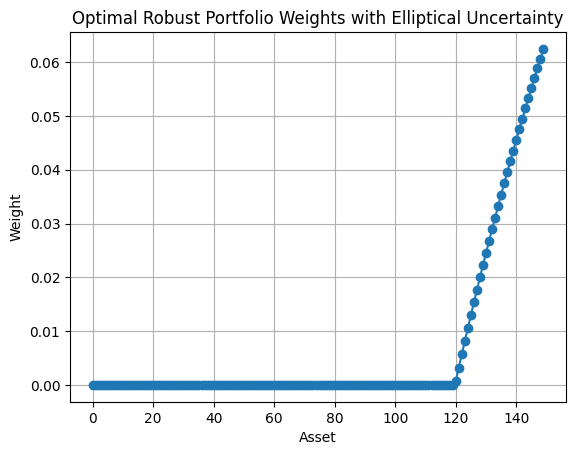

In [ ]:
class RobustPortfolioOptimizerWithEllipticalUncertainty:
    def __init__(self, n_stocks, lambda_val, delta, Sigma_hat):
        self.n = n_stocks  # Number of stocks
        self.lambda_val = lambda_val  # Risk aversion coefficient
        self.delta = delta  # Delta for the elliptical uncertainty radius
        self.Sigma_hat = Sigma_hat  # Estimated covariance matrix

        # Define nominal mean returns
        self.mu_hat = 1.15 + np.arange(1, n_stocks + 1) * 0.05 / n_stocks
        self.S_half = np.linalg.cholesky(Sigma_hat)  # Cholesky decomposition for S^(1/2)

    def objective(self, w):
        expected_return = np.dot(self.mu_hat, w)
        variance = np.dot(w.T, np.dot(self.Sigma_hat, w))
        # Calculate the worst-case deviation within the uncertainty ellipsoid
        deviation = self.delta * np.linalg.norm(np.dot(self.S_half.T, w))

        # Total risk adjusted return
        risk_adjusted_return = expected_return - self.lambda_val * variance - deviation

        return -risk_adjusted_return  # Negative because we want to maximize the original objective

    def constraint_sum(self, w):
        return np.sum(w) - 1

    def solve_optimization(self):
        constraints = {'type': 'eq', 'fun': self.constraint_sum}
        bounds = [(0, 1) for _ in range(self.n)]
        x0 = np.repeat(1 / self.n, self.n)
        result = minimize(self.objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')
        return result.x  # Return only the weights

    def plot_solution(self, weights):
        plt.plot(np.arange(self.n), weights, '-o')
        plt.xlabel('Asset')
        plt.ylabel('Weight')
        plt.title('Optimal Robust Portfolio Weights with Elliptical Uncertainty')
        plt.grid(True)
        plt.show()

# Usage example:
n_stocks = 150
lambda_val = 0.5
delta = 0.05
Sigma_hat = np.diag((0.05 / 450 * (2 * np.arange(1, n_stocks + 1) * n_stocks * (n_stocks + 1))**0.5)**2)

robust_optimizer = RobustPortfolioOptimizerWithEllipticalUncertainty(n_stocks, lambda_val, delta, Sigma_hat)
optimal_weights = robust_optimizer.solve_optimization()
robust_optimizer.plot_solution(optimal_weights)


We can see that robust formulation set more weights to zero in response to worse-case scenarios of the estimation error of mean returns. In this case, the corresponding penalty is a scaled L2 norm of the weights. Essentially, we would like the solution (optimal portfolio weights) to be both *stable* and *diverse* via robust formulation.

## Spherical Uncertainty Applied to the Covariance Matrix

This section introduces the Frobenius norm for integrating an aggregate uncertainty into the covariance matrix. This norm quantifies the size of the matrix as the square root of the sum of the squares of its elements, effectively encapsulating the matrix within a multidimensional spherical boundary. We revisit the concept of a perturbation matrix $\Delta$, now applied to the input design matrix $\boldsymbol{X} \in \mathbb{R}^{T \times N}$, where $T$ represents time periods and $N$ denotes the number of assets, thus:

$$
\boldsymbol{X} = \boldsymbol{\hat X} + \Delta
$$

Here, $\Delta$ is constrained by the Frobenius norm as follows:

$$
\| \Delta \|_F \leq \delta_{\boldsymbol{X}}
$$

This formulation introduces a spherical uncertainty set, $U_{\boldsymbol{X}}$, defined for the design matrix $\boldsymbol{X}$:

$$
U_{\boldsymbol{X}} = \{ \boldsymbol{X} | \| \boldsymbol{X} - \boldsymbol{\hat X} \|_F \leq \delta_{\boldsymbol{X}} \}
$$

The uncertainty captured in the (demeaned) matrix $\boldsymbol{X}$ directly influences the covariance matrix $\boldsymbol{\Sigma}$, given by $\boldsymbol{\Sigma}=\frac{1}{T}\boldsymbol{X}^T\boldsymbol{X}$. This relation modifies the risk component in MVO as follows:

$$
\begin{aligned}
    \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w} &= \mathbf{w}^T \frac{1}{T}\boldsymbol{X}^T\boldsymbol{X} \mathbf{w} \\
    &= \frac{1}{T}  (\boldsymbol{X} \mathbf{w})^T \boldsymbol{X} \mathbf{w} \\
    &= \frac{1}{T} \| \boldsymbol{X} \mathbf{w} \|_2^2 \\
    &= \frac{1}{T} \| (\boldsymbol{\hat X} + \Delta) \mathbf{w} \|_2^2
\end{aligned}
$$

Consequently, the robust MVO framework seeks to maximize the worst-case risk term:

$$
\underset{\boldsymbol{X} \in U_{\boldsymbol{X}}}{\text{max}} \| \boldsymbol{X} \mathbf{w} \|_2^2 =
\underset{\| \Delta \|_F \leq \delta_{\boldsymbol{X}}}{\text{max}} \| (\boldsymbol{\hat X} + \Delta) \mathbf{w} \|_2^2
$$

Disregarding the constant factor $\frac{1}{T}$, the robust MVO model is reformulated as:

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \boldsymbol{\mu}^T \mathbf{w} - \lambda \underset{\| \Delta \|_F \leq \delta_{\boldsymbol{X}}}{\text{max}} \| (\boldsymbol{\hat X} + \Delta) \mathbf{w} \|_2^2 \\
& \text{subject to}
& & \mathbf{w}^T \mathbf{1} = 1, \\
& & & w_i \geq 0, \quad \forall i \in \{1, \ldots, n\}.
\end{aligned}
$$

Using the triangular inequality, we deduce:

$$
\| (\boldsymbol{\hat X} + \Delta) \mathbf{w} \|_2 \leq \| \boldsymbol{\hat X} \mathbf{w} \|_2 +  \| \Delta \mathbf{w} \|_2
$$

And from the norm inequality, it follows that:

$$
\| \Delta \mathbf{w} \|_2 \leq \| \Delta \|_F \|\mathbf{w} \|_2 \leq \delta_{\boldsymbol{X}} \|\mathbf{w} \|_2
$$

Thus, the expression for the worst-case risk maximization simplifies to:

$$
\underset{\| \Delta \|_F \leq \delta_{\boldsymbol{X}}}{\text{max}} \| (\boldsymbol{\hat X} + \Delta) \mathbf{w} \|_2^2 = (\| \boldsymbol{\hat X} \mathbf{w} \|_2 + \delta_{\boldsymbol{X}} \|\mathbf{w} \|_2)^2
$$

Accordingly, the refined robust MVO framework is presented as follows.

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \boldsymbol{\mu}^T \mathbf{w} - \lambda (\| \boldsymbol{\hat X} \mathbf{w} \|_2 + \delta_{\boldsymbol{X}} \|\mathbf{w} \|_2)^2 \\
& \text{subject to}
& & \mathbf{w}^T \mathbf{1} = 1, \\
& & & w_i \geq 0, \quad \forall i \in \{1, \ldots, n\}.
\end{aligned}
$$

This formulation represents a Second-Order Cone Problem (SOCP), offering a structured approach to addressing uncertainty in portfolio optimization through the lens of the Frobenius norm.



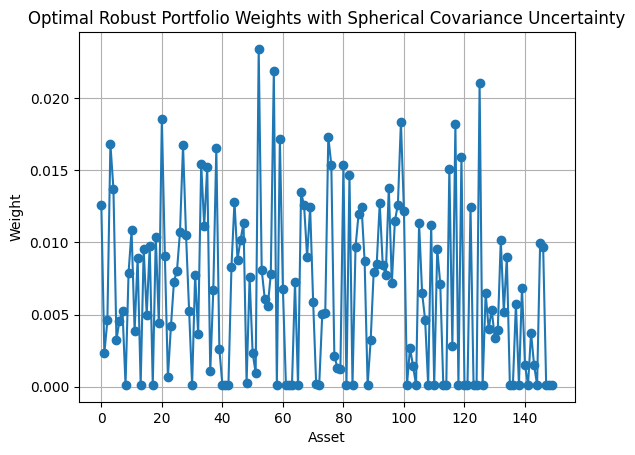

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.linalg import norm

class RobustPortfolioOptimizerWithSphericalCovarianceUncertainty:
    def __init__(self, n_assets, n_periods, lambda_val, delta_X, mu_hat, X_hat):
        self.n = n_assets  # Number of assets
        self.T = n_periods  # Number of time periods
        self.lambda_val = lambda_val  # Risk aversion coefficient
        self.delta_X = delta_X  # Delta for the spherical uncertainty radius
        self.mu_hat = mu_hat  # Estimated mean returns vector
        self.X_hat = X_hat  # Nominal design matrix (demeaned returns)

    def objective(self, w):
        expected_return = np.dot(self.mu_hat, w)

        # Norm of the product of the nominal design matrix X_hat and the weight vector w
        Xw_norm = np.linalg.norm(np.dot(self.X_hat, w), 2)

        # Norm of the weight vector w
        w_norm = np.linalg.norm(w, 2)

        # Risk term considering the spherical uncertainty
        risk_term = (Xw_norm + self.delta_X * w_norm)**2

        # Objective is to maximize return and minimize risk (including the worst-case risk)
        return -(expected_return - self.lambda_val * risk_term)


    def constraint_sum(self, w):
        return np.sum(w) - 1

    def solve_optimization(self):
        constraints = {'type': 'eq', 'fun': self.constraint_sum}
        bounds = [(0, 1) for _ in range(self.n)]
        x0 = np.repeat(1 / self.n, self.n)
        result = minimize(self.objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')
        return result.x  # Return only the weights

    def plot_solution(self, weights):
        plt.plot(np.arange(self.n), weights, '-o')
        plt.xlabel('Asset')
        plt.ylabel('Weight')
        plt.title('Optimal Robust Portfolio Weights with Spherical Covariance Uncertainty')
        plt.grid(True)
        plt.show()

# Usage example
n_assets = 150
n_periods = 250  # An example number of periods
lambda_val = 0.5
delta_X = 0.05
mu_hat = 1.15 + np.arange(1, n_assets + 1) * 0.05 / n_assets
X_hat = np.random.randn(n_periods, n_assets)  # Simulated nominal design matrix

robust_optimizer = RobustPortfolioOptimizerWithSphericalCovarianceUncertainty(n_assets, n_periods, lambda_val, delta_X, mu_hat, X_hat)
optimal_weights = robust_optimizer.solve_optimization()
robust_optimizer.plot_solution(optimal_weights)
